In [2]:
import os
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import PyPDF2
from pdfminer.high_level import extract_text as pdfminer_extract_text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import fitz  # PyMuPDF
import io
from PIL import Image
import pytesseract
# pdf2image import removed - using PyMuPDF (fitz) instead
import numpy as np
from pathlib import Path
import csv
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


In [ ]:
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')

In [4]:
french_stopwords = set(stopwords.words('french'))

In [5]:
# Configuration for OCR and paths
# Data paths
PDF_DIRECTORY = "./data"
OUTPUT_DIRECTORY = "./output"
if not os.path.exists(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

# OCR settings
OCR_LANGUAGE = 'fra' 

# Check if required OCR tools are installed
TESSERACT_INSTALLED = True

# Try to find Tesseract
try:
    # Common paths for Tesseract on Windows
    tesseract_paths = [
        r'E:\tessarct\tesseract.exe',
        r'C:\Program Files\Tesseract-OCR\tesseract.exe',
        r'C:\Program Files (x86)\Tesseract-OCR\tesseract.exe',
    ]
    
    # Try each path until we find one that works
    for path in tesseract_paths:
        if os.path.exists(path):
            # Set the Tesseract executable path
            pytesseract.pytesseract.tesseract_cmd = path
            print(f"Found Tesseract at: {path}")
            
            # Set the TESSDATA_PREFIX environment variable to point to the tessdata directory
            # The tessdata directory should be in the same folder as the tesseract executable
            tessdata_path = os.path.join(os.path.dirname(path), 'tessdata')
            os.environ['TESSDATA_PREFIX'] = tessdata_path
            print(f"Set TESSDATA_PREFIX to: {tessdata_path}")
            break
    
    # Test if Tesseract works
    version = pytesseract.get_tesseract_version()
    print(f"Tesseract version: {version}")
except Exception as e:
    print(f"Tesseract OCR not found or not working: {str(e)}")
    print("Download Tesseract from: https://github.com/UB-Mannheim/tesseract/wiki")
    TESSERACT_INSTALLED = False

# Check if PyMuPDF (fitz) is working
try:
    # Test if PyMuPDF works by opening a PDF
    test_pdf = os.path.join(PDF_DIRECTORY, os.listdir(PDF_DIRECTORY)[0])
    _ = fitz.open(test_pdf)
    print("PyMuPDF PDF processing is working correctly")
except Exception as e:
    print(f"Error with PyMuPDF PDF processing: {str(e)}")
    print("Make sure the PyMuPDF library is correctly installed: pip install PyMuPDF")

# PDF processing settings
MAX_IMAGES_PER_PDF = 20  # Limit for number of images to extract per PDF
IMAGE_QUALITY = 300  # DPI for page-to-image conversion
MAX_PAGE_LIMIT = 30  # Maximum number of pages to process for very large PDFs


Found Tesseract at: E:\tessarct\tesseract.exe
Set TESSDATA_PREFIX to: E:\tessarct\tessdata
Tesseract version: 5.5.0.20241111
PyMuPDF PDF processing is working correctly


In [6]:
def check_if_pdf_has_text(file_path):
    """Vérifie si un PDF contient du texte extractible."""
    try:
        with open(file_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            if len(reader.pages) > 0:
                page = reader.pages[0]  # Vérifier seulement la première page
                text = page.extract_text()
                return bool(text and len(text) > 50)  # Considérer qu'il y a du texte si plus de 50 caractères
    except Exception as e:
        print(f"Erreur lors de la vérification du PDF {os.path.basename(file_path)}: {str(e)}")
    return False

In [7]:
def get_pdf_metadata(directory="./data", return_raw=False):
    """
    Collecte les métadonnées des fichiers PDF
    Args:
        return_raw: Si True retourne le dataframe brut, False retourne les stats
    Returns:
        DataFrame ou tuple (DataFrame, DataFrame) selon return_raw
    """
    files = list(Path(directory).glob("**/*.pdf"))
    
    if not files:
        print(f"AVERTISSEMENT: Aucun fichier PDF trouvé dans {directory} ou ses sous-répertoires.")
        if return_raw:
            return pd.DataFrame()
        else:
            return pd.DataFrame(), pd.DataFrame({
                'total_files': [0],
                'avg_size_kb': [0],
                'max_size_kb': [0],
                'min_size_kb': [0]
            })
    
    meta_df = pd.DataFrame([{
        'file_name': f.name,
        'file_path': str(f),
        'file_size_kb': round(f.stat().st_size / 1024, 2),
        'last_modified': pd.to_datetime(f.stat().st_mtime, unit='s'),
        'has_text': check_if_pdf_has_text(str(f))
    } for f in files if f.is_file()])
    
    if return_raw:
        return meta_df
    
    stats_df = pd.DataFrame({
        'total_files': [len(meta_df)],
        'avg_size_kb': [round(meta_df['file_size_kb'].mean(), 2)],
        'max_size_kb': [meta_df['file_size_kb'].max()],
        'min_size_kb': [meta_df['file_size_kb'].min()],
        'files_with_text': [sum(meta_df['has_text'])]
    })
    
    return meta_df, stats_df

In [8]:
meta_df, stats_df = get_pdf_metadata("./data")
print(f"Found {stats_df['total_files'][0]} PDF files")

print(stats_df)

Erreur lors de la vérification du PDF b5465035-189b-4842-bfec-59524fae357c_636561016472005858DI_et_Avis_RSC_ADJ_ADM_2018.pdf: PyCryptodome is required for AES algorithm
Found 850 PDF files
   total_files  avg_size_kb  max_size_kb  min_size_kb  files_with_text
0          850       347.55      4259.71         9.34              460


In [9]:
def list_pdf_files(directory="./data"):
    """Liste tous les fichiers PDF dans le répertoire spécifié."""
    # Vérifier que le répertoire existe
    if not os.path.exists(directory):
        print(f"ERREUR: Le répertoire {directory} n'existe pas!")
        return []
    
    pdf_files = []
    
    # Essayer avec récursivité
    try:
        pdf_files = glob.glob(os.path.join(directory, "**/*.pdf"), recursive=True)
    except:
        pass
    
    # Si aucun fichier trouvé, essayer avec os.walk
    if not pdf_files:
        for root, _, files in os.walk(directory):
            for file in files:
                if file.lower().endswith('.pdf'):
                    pdf_files.append(os.path.join(root, file))
    
    return pdf_files


In [10]:
def extract_text_with_pypdf2(filepath):
    """Extrait le texte d'un fichier PDF en utilisant PyPDF2."""
    try:
        with open(filepath, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            text = ""
            for page_num in range(len(reader.pages)):
                text += reader.pages[page_num].extract_text() + "\n"
            return text
    except Exception as e:
        print(f"Erreur avec PyPDF2: {str(e)}")
        return ""

def extract_text_with_pdfminer(filepath):
    """Extrait le texte d'un fichier PDF en utilisant pdfminer.six."""
    try:
        return pdfminer_extract_text(filepath)
    except Exception as e:
        print(f"Erreur avec pdfminer: {str(e)}")
        return ""

In [11]:
def analyze_pdf_content(file_paths, ignore_errors=False, error_summary=True):
    """
    Analyse le contenu des fichiers PDF avec une gestion avancée des erreurs.
    
    Args:
        file_paths: Liste des chemins de fichiers
        ignore_errors: Si True, continue malgré les erreurs
        error_summary: Si True, affiche un résumé des erreurs à la fin
        sample_size: Limiter à un échantillon de cette taille
    
    Returns:
        DataFrame des statistiques, texte concaténé, DataFrame des erreurs
    """
    # Limiter à un échantillon si nécessaire

    
    content_stats = []
    all_text = ""
    success_count = 0
    error_count = 0
    error_records = []  # Pour stocker les informations d'erreur
    
    for file_path in file_paths:
        try:
            file_name = os.path.basename(file_path)
            
            # Extraire le texte avec pdfminer (meilleure qualité)
            text = extract_text_with_pdfminer(file_path)
            
            # Si pdfminer échoue, essayer PyPDF2
            if not text:
                text = extract_text_with_pypdf2(file_path)
            
            # Si toujours pas de texte, c'est probablement un PDF d'image
            if not text or len(text.strip()) < 100:
                error_records.append({
                    'file_name': file_name,
                    'file_type': 'PDF',
                    'error_type': 'EmptyContent',
                    'error_message': 'Aucun contenu textuel extrait (possible PDF scanné)',
                    'extraction_step': 'Content validation'
                })
                error_count += 1
                continue
            
            # Calculer les statistiques
            all_text += " " + text
            
            # Diviser en paragraphes (par défaut sur les sauts de ligne)
            paragraphs = [p for p in text.split('\n') if p.strip()]
            
            # Estimer le nombre de lignes
            lines = text.count('\n') + 1
            
            # Compter les mots
            word_count = len(text.split())
            
            # Compter les caractères
            char_count = len(text)
            
            # Ajouter aux statistiques
            content_stats.append({
                'file_name': file_name,
                'word_count': word_count,
                'char_count': char_count,
                'paragraph_count': len(paragraphs),
                'line_count': lines,
                'file_type': 'PDF'
            })
            success_count += 1
            
        except Exception as e:
            error_records.append({
                'file_name': os.path.basename(file_path),
                'file_type': 'PDF',
                'error_type': type(e).__name__,
                'error_message': str(e),
                'extraction_step': 'General processing'
            })
            if not ignore_errors:
                print(f"❌ Erreur générale {os.path.basename(file_path)}: {type(e).__name__}")
            error_count += 1
    
    # Créer un DataFrame des erreurs pour analyse
    errors_df = pd.DataFrame(error_records)
    
    # Afficher un résumé des erreurs
    if error_summary and not errors_df.empty:
        print("\n--- RÉSUMÉ DES ERREURS ---")
        error_types = errors_df['error_type'].value_counts()
        print(f"Types d'erreurs rencontrés ({len(errors_df)} fichiers problématiques):")
        for error_type, count in error_types.items():
            print(f"  • {error_type}: {count} fichiers")
        
        # Afficher quelques exemples de chaque type d'erreur
        print("\nExemples d'erreurs par type:")
        for error_type in error_types.index:
            examples = errors_df[errors_df['error_type'] == error_type].head(5)
            print(f"\n  {error_type}:")
            for _, err in examples.iterrows():
                print(f"    - {err['file_name']}: {err['error_message']}")
    
    print(f"\nAnalyse terminée: {success_count} fichiers traités avec succès, {error_count} erreurs")
    return pd.DataFrame(content_stats), all_text, errors_df

In [12]:
pdf_files = list_pdf_files("./data")  
content_df, all_text, _ = analyze_pdf_content(pdf_files)
# Vérifier le contenu extrait
print(f"Contenu extrait de {len(content_df)} fichiers PDF")
display(content_df.head())



Cannot set gray non-stroke color because /'P25' is an invalid float value
Cannot set gray non-stroke color because /'P27' is an invalid float value
Cannot set gray non-stroke color because /'P37' is an invalid float value
Cannot set gray non-stroke color because /'P40' is an invalid float value
Cannot set gray non-stroke color because /'P41' is an invalid float value
Cannot set gray non-stroke color because /'P42' is an invalid float value
Cannot set gray non-stroke color because /'P43' is an invalid float value
Cannot set gray non-stroke color because /'P44' is an invalid float value
Cannot set gray non-stroke color because /'P45' is an invalid float value
Cannot set gray non-stroke color because /'P46' is an invalid float value
Cannot set gray non-stroke color because /'P47' is an invalid float value
Cannot set gray non-stroke color because /'P48' is an invalid float value
Cannot set gray non-stroke color because /'P49' is an invalid float value
Cannot set gray non-stroke color becau


--- RÉSUMÉ DES ERREURS ---
Types d'erreurs rencontrés (389 fichiers problématiques):
  • EmptyContent: 389 fichiers

Exemples d'erreurs par type:

  EmptyContent:
    - 0006f5d8-6205-45c1-a814-b43e198e5a66_635624456875534275charge_e__de_com_APEI_Thionville.pdf: Aucun contenu textuel extrait (possible PDF scanné)
    - 02527914-5bb8-4268-bb8d-ddb02727c51a_636310643839448757SKM_C25817052215460.pdf: Aucun contenu textuel extrait (possible PDF scanné)
    - 02de0492-c7d5-4848-a62c-141e5a3d66db_634866039394933734Fensch.pdf: Aucun contenu textuel extrait (possible PDF scanné)
    - 03682d82-3607-48c4-92de-0d6466c8ac25_634493708927160000OFFRE_ASH.pdf: Aucun contenu textuel extrait (possible PDF scanné)
    - 03939f7d-5cf9-4e34-a6c0-9e2b3a5d28eb_638182099570459946APEI_Agent_d_entretien.pdf: Aucun contenu textuel extrait (possible PDF scanné)

Analyse terminée: 461 fichiers traités avec succès, 389 erreurs
Contenu extrait de 461 fichiers PDF


,file_name,word_count,char_count,paragraph_count,line_count,file_type
0,01ee0ca2-3cb0-4c40-8c13-9ad13a297d54_637286813...,238,1674,41,78,PDF
1,020a7263-1079-4a5d-afa5-71af7b5db0d8_638126717...,290,1903,37,74,PDF
2,02e7501a-3149-4ed4-b9fd-411e03a55429_635442352...,145,1055,29,63,PDF
3,046b66b4-db42-4af3-b020-3d362444e8bc_636670839...,262,1886,64,104,PDF
4,04b6216c-a443-4cd8-9129-c189d2d06b23_635581470...,479,3181,109,135,PDF


In [13]:
def plot_top_words(word_freq, top_n=30):
    """Visualise les mots les plus fréquents."""
    top_words = pd.DataFrame(word_freq.most_common(top_n), columns=['Mot', 'Fréquence'])
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Fréquence', y='Mot', data=top_words)
    plt.title(f'Top {top_n} des mots les plus fréquents dans les PDF')
    plt.tight_layout()
    return plt



In [14]:
def plot_generate_wordcloud(filtered_tokens):
    """Génère un nuage de mots à partir des tokens filtrés."""
    text_for_wordcloud = ' '.join(filtered_tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                         max_words=100, contour_width=1, contour_color='steelblue',
                         collocations=False).generate(text_for_wordcloud)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Nuage de mots des documents PDF", fontsize=20)
    plt.tight_layout()
    return plt

In [15]:
def analyze_word_frequencies(text):
    """Analyse les fréquences de mots dans le texte fourni."""
    # Nettoyer le texte
    cleaned_text = re.sub(r'[^\w\s]', ' ', text.lower())
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    # Tokeniser le texte
    tokens = word_tokenize(cleaned_text, language='french')
    
    # Filtrer les stopwords
    filtered_tokens = [token for token in tokens if token not in french_stopwords and len(token) > 2]
    
    # Compter les fréquences
    word_freq = Counter(filtered_tokens)
    return word_freq, filtered_tokens

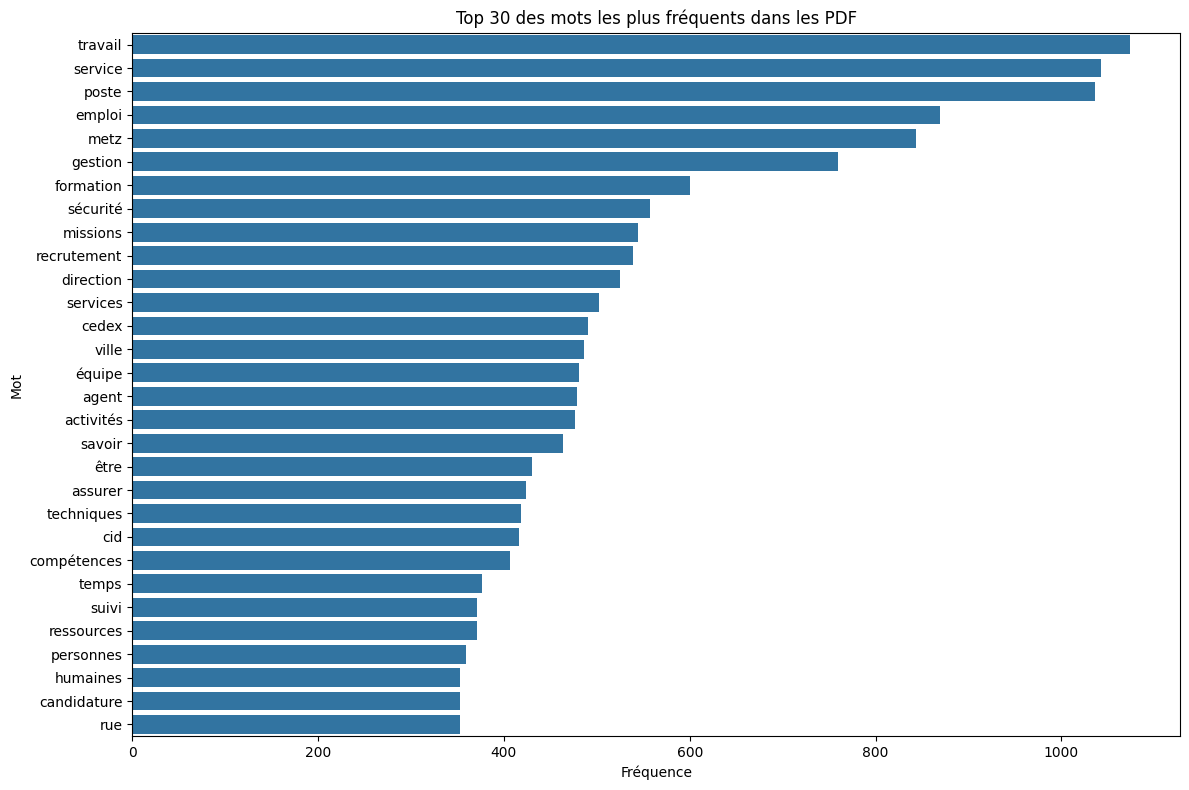

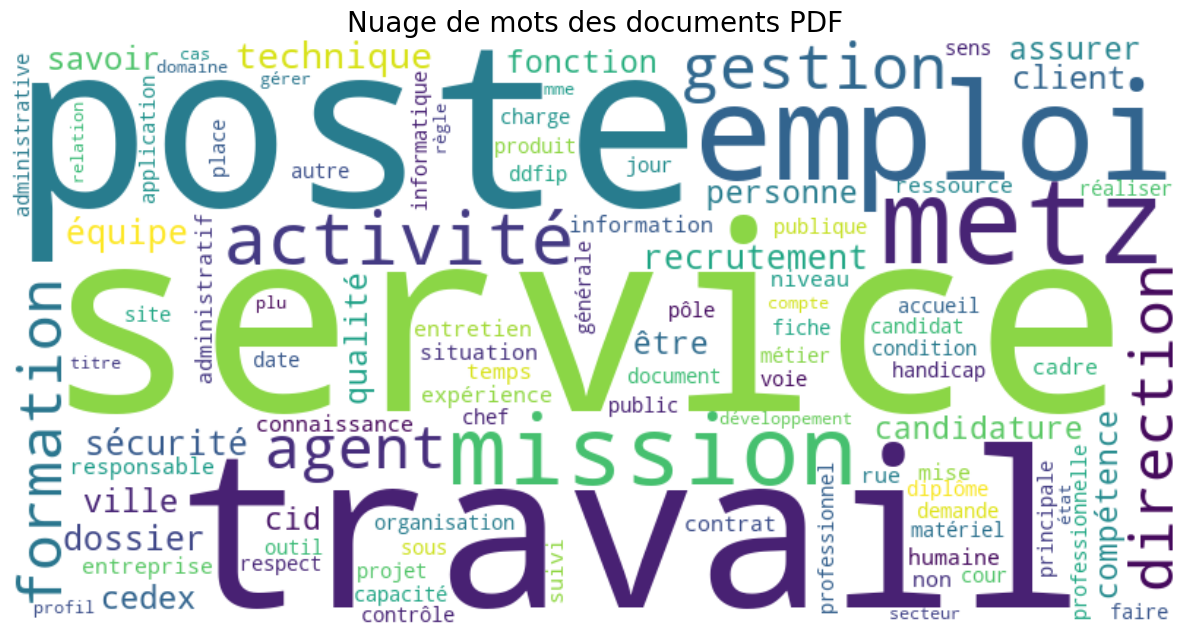

In [16]:
if not content_df.empty:
    
    # Analyser les fréquences de mots
    word_freq, filtered_tokens = analyze_word_frequencies(all_text)
    
    # Visualiser
    plot_top_words(word_freq).show()
    plot_generate_wordcloud(filtered_tokens).show()

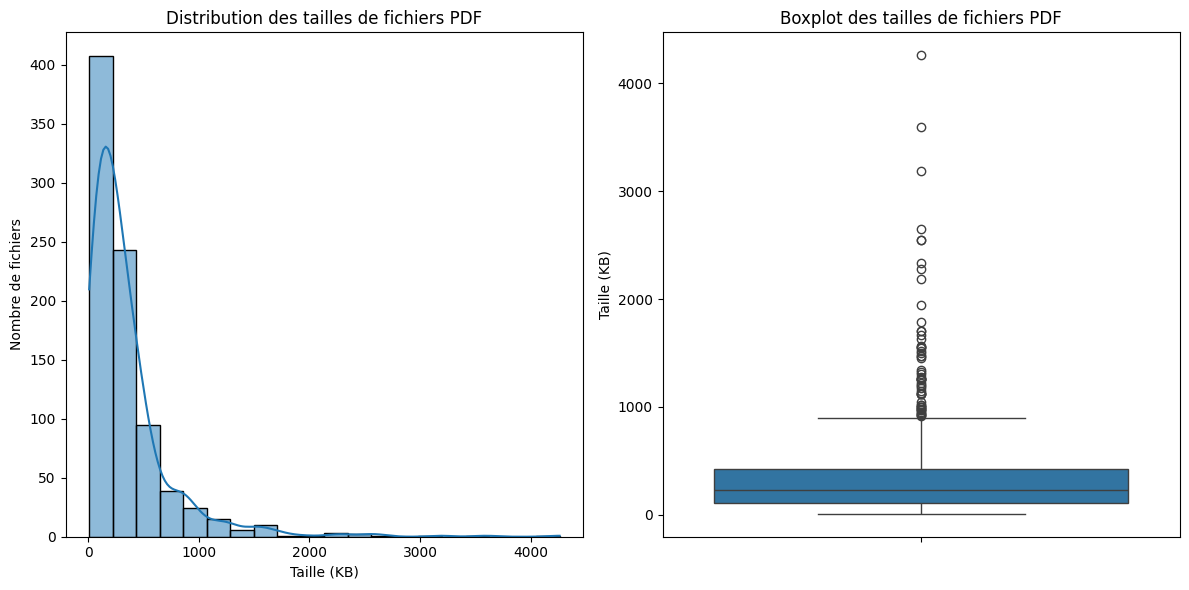

In [17]:
def plot_file_size_distribution(pdf_info_df):
    """Visualise la distribution des tailles de fichiers."""
    plt.figure(figsize=(12, 6))
    
    # Histogramme des tailles de fichiers
    plt.subplot(1, 2, 1)
    sns.histplot(pdf_info_df['file_size_kb'], bins=20, kde=True)
    plt.title('Distribution des tailles de fichiers PDF')
    plt.xlabel('Taille (KB)')
    plt.ylabel('Nombre de fichiers')
    
    # Boxplot pour voir les outliers
    plt.subplot(1, 2, 2)
    sns.boxplot(y=pdf_info_df['file_size_kb'])
    plt.title('Boxplot des tailles de fichiers PDF')
    plt.ylabel('Taille (KB)')
    
    plt.tight_layout()
    return plt

plot_file_size_distribution(meta_df).show()

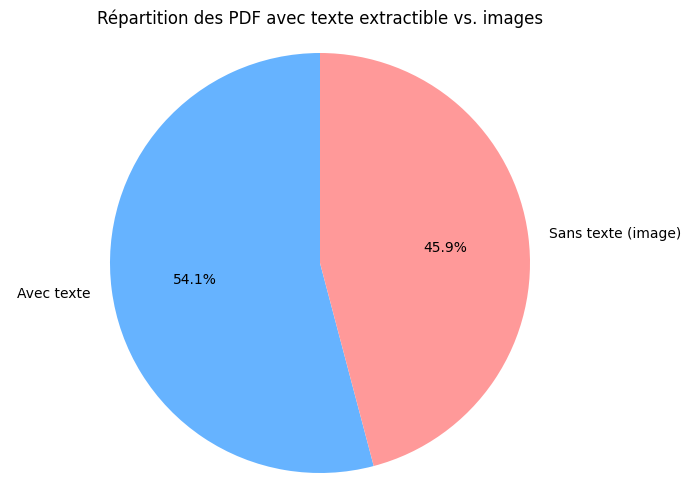

In [18]:
def plot_text_vs_image_distribution(pdf_info_df):
    """Visualise la répartition des PDF avec texte vs. images."""
    plt.figure(figsize=(8, 6))
    text_counts = pdf_info_df['has_text'].value_counts()
    labels = ['Avec texte', 'Sans texte (image)']
    
    # Créer un graphique circulaire
    plt.pie([text_counts.get(True, 0), text_counts.get(False, 0)], 
            labels=labels, 
            autopct='%1.1f%%', 
            startangle=90, 
            colors=['#66b3ff', '#ff9999'])
    
    plt.title('Répartition des PDF avec texte extractible vs. images')
    plt.axis('equal')
    return plt

plot_text_vs_image_distribution(meta_df).show()

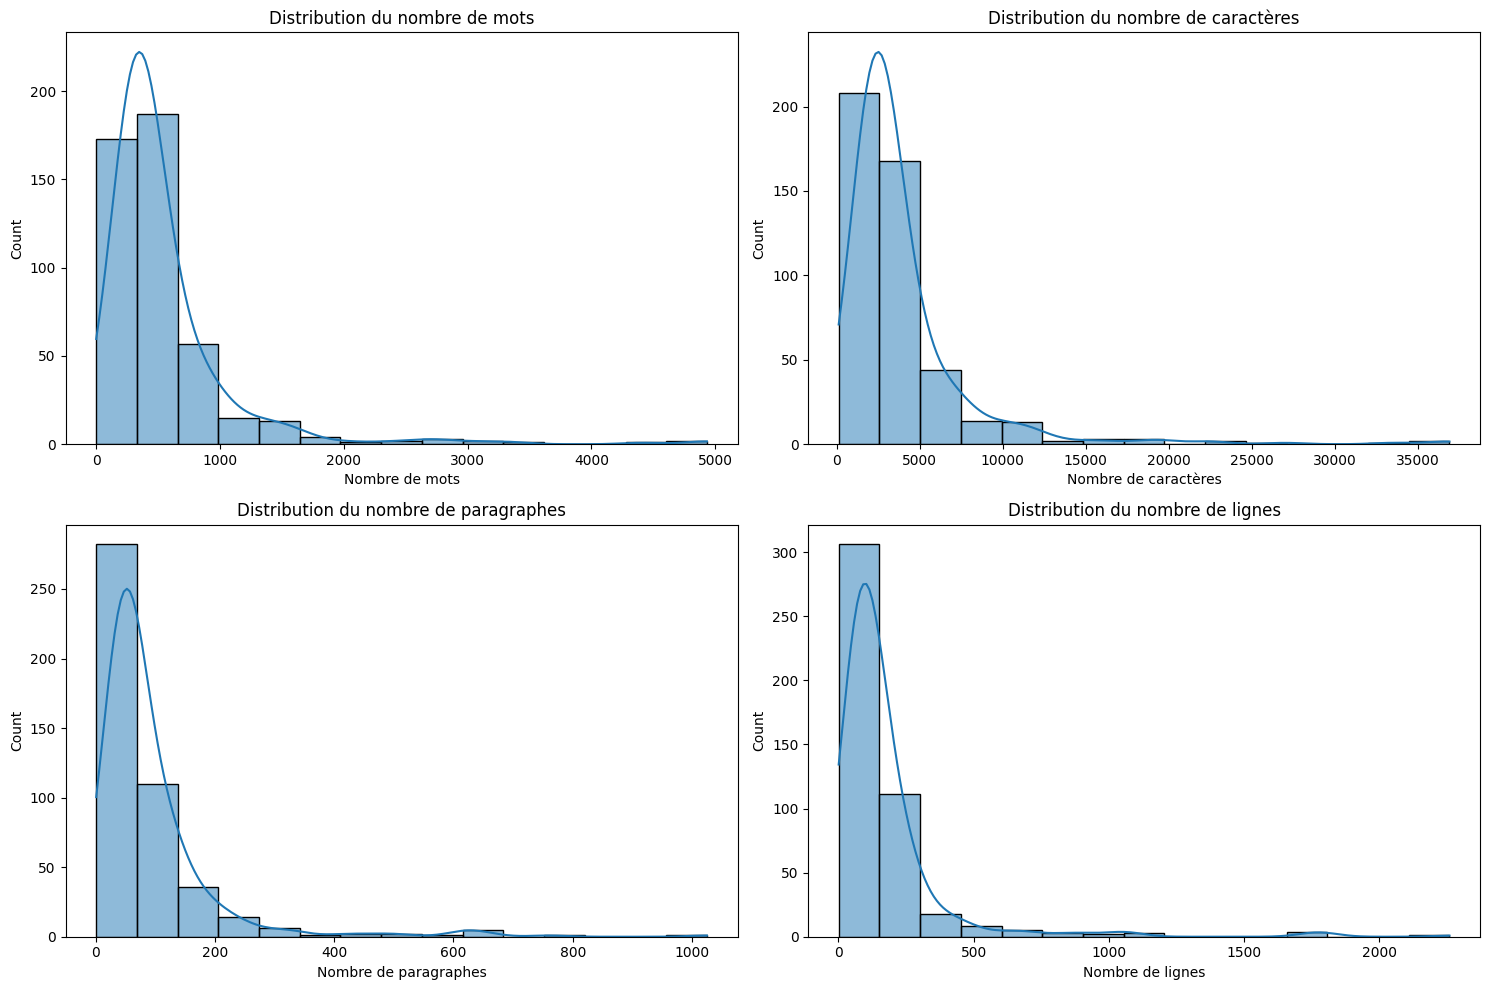

In [19]:
def plot_content_stats_distribution(content_stats_df):
    """Visualise les distributions des statistiques de contenu."""
    plt.figure(figsize=(15, 10))
    
    # Distribution du nombre de mots
    plt.subplot(2, 2, 1)
    sns.histplot(content_stats_df['word_count'], bins=15, kde=True)
    plt.title('Distribution du nombre de mots')
    plt.xlabel('Nombre de mots')
    
    # Distribution du nombre de caractères
    plt.subplot(2, 2, 2)
    sns.histplot(content_stats_df['char_count'], bins=15, kde=True)
    plt.title('Distribution du nombre de caractères')
    plt.xlabel('Nombre de caractères')
    
    # Distribution du nombre de paragraphes
    plt.subplot(2, 2, 3)
    sns.histplot(content_stats_df['paragraph_count'], bins=15, kde=True)
    plt.title('Distribution du nombre de paragraphes')
    plt.xlabel('Nombre de paragraphes')
    
    # Distribution du nombre de lignes
    plt.subplot(2, 2, 4)
    sns.histplot(content_stats_df['line_count'], bins=15, kde=True)
    plt.title('Distribution du nombre de lignes')
    plt.xlabel('Nombre de lignes')
    
    plt.tight_layout()
    return plt

plot_content_stats_distribution(content_df).show()

In [20]:
def extract_images_from_pdf(filepath, output_folder=None, max_images=MAX_IMAGES_PER_PDF):
    """Extract images from a PDF file.
    
    Args:
        filepath: Path to the PDF file
        output_folder: Folder to save extracted images (if None, images are not saved to disk)
        max_images: Maximum number of images to extract
        
    Returns:
        List of extracted images as PIL Image objects
    """
    try:
        # Open the PDF
        pdf_file = fitz.open(filepath)
        images = []
        image_count = 0
        file_basename = os.path.splitext(os.path.basename(filepath))[0]
        
        # Create output folder if specified and doesn't exist
        if output_folder and not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        # Iterate through pages
        for page_index in range(len(pdf_file)):
            # Stop if we've reached the maximum image limit
            if image_count >= max_images:
                break
                
            page = pdf_file[page_index]
            
            # Get image list
            image_list = page.get_images(full=True)
            
            for img_index, img in enumerate(image_list):
                # Stop if we've reached the maximum image limit
                if image_count >= max_images:
                    break
                    
                try:
                    xref = img[0]  # Reference number for the image
                    base_image = pdf_file.extract_image(xref)
                    image_bytes = base_image["image"]
                    image_ext = base_image["ext"]
                    
                    # Convert bytes to PIL Image
                    image = Image.open(io.BytesIO(image_bytes))
                    
                    # Add to our list
                    images.append({
                        'image': image,
                        'page': page_index + 1,
                        'index': img_index,
                        'width': image.width,
                        'height': image.height
                    })
                    
                    # Save to disk if output folder provided
                    if output_folder:
                        image_filename = f"{file_basename}_page{page_index+1}_img{img_index}.{image_ext}"
                        image_path = os.path.join(output_folder, image_filename)
                        with open(image_path, "wb") as f:
                            f.write(image_bytes)
                    
                    image_count += 1
                except Exception as e:
                    print(f"Error extracting image {img_index} from page {page_index+1}: {str(e)}")
        
        return images
    
    except Exception as e:
        print(f"Error extracting images from PDF {filepath}: {str(e)}")
        return []


In [21]:
def extract_text_with_ocr(image, lang=OCR_LANGUAGE):
    """Extract text from an image using OCR.
    
    Args:
        image: PIL Image object
        lang: Language code for OCR
        
    Returns:
        Extracted text string
    """
    global TESSERACT_INSTALLED  # Reference the global variable
    
    if not TESSERACT_INSTALLED:
        return "[OCR TEXT EXTRACTION FAILED: Tesseract OCR is not installed]"
        
    try:
        text = pytesseract.image_to_string(image, lang=lang)
        return text
    except Exception as e:
        print(f"OCR Error: {str(e)}")
        return f"[OCR ERROR: {str(e)}]"

def extract_text_from_pdf_images(filepath, lang=OCR_LANGUAGE, dpi=IMAGE_QUALITY, max_pages=MAX_PAGE_LIMIT):
    """Convert PDF pages to images and extract text using OCR.
    
    Args:
        filepath: Path to the PDF file
        lang: Language code for OCR
        dpi: DPI for PDF to image conversion quality
        max_pages: Maximum number of pages to process
        
    Returns:
        Extracted text string from all pages
    """
    global TESSERACT_INSTALLED  # Reference the global variable
    
    if not TESSERACT_INSTALLED:
        return "[IMAGE-BASED PDF DETECTED: Tesseract OCR is not installed. Please install Tesseract to extract text from this PDF.]"
        
    try:
        # Convert PDF to images using PyMuPDF (fitz) - no Poppler required
        print(f"Converting PDF to images using PyMuPDF: {os.path.basename(filepath)}")
        try:
            images = convert_pdf_to_images_with_fitz(filepath, dpi=dpi, max_pages=max_pages)
        except Exception as pdf_error:
            return f"[PDF CONVERSION ERROR: {str(pdf_error)}]"
        
        if not images:
            return "[No images could be extracted from this PDF]"
            
        full_text = ""
        for i, image in enumerate(images):
            print(f"Processing page {i+1}/{len(images)} with OCR")
            page_text = extract_text_with_ocr(image, lang)
            if page_text:
                full_text += f"\n--- Page {i+1} ---\n{page_text}"
            else:
                full_text += f"\n--- Page {i+1} ---\n[No text extracted]"
        
        if not full_text.strip():
            return "[OCR processing completed but no text was extracted]"
            
        return full_text
    except Exception as e:
        error_message = f"Error in image-based extraction: {str(e)}"
        print(error_message)
        return f"[ERROR: {error_message}]"


In [22]:
def convert_pdf_to_images_with_fitz(filepath, dpi=IMAGE_QUALITY, max_pages=MAX_PAGE_LIMIT):
    """Convert PDF pages to images using PyMuPDF (fitz) without requiring Poppler.
    
    Args:
        filepath: Path to the PDF file
        dpi: DPI for rendering quality (higher is better quality but slower)
        max_pages: Maximum number of pages to process
        
    Returns:
        List of PIL Image objects for each page
    """
    try:
        # Open the PDF
        pdf_document = fitz.open(filepath)
        page_count = len(pdf_document)
        
        # Calculate zoom factor based on desired DPI
        # Standard PDF resolution is 72 DPI, so zoom factor is target DPI / 72
        zoom_factor = dpi / 72
        transform_matrix = fitz.Matrix(zoom_factor, zoom_factor)
        
        # Limit the number of pages to process
        pages_to_process = min(page_count, max_pages)
        
        images = []
        for page_num in range(pages_to_process):
            print(f"Converting page {page_num+1}/{pages_to_process} to image")
            
            # Get the page
            page = pdf_document[page_num]
            
            # Render page to image
            pix = page.get_pixmap(matrix=transform_matrix, alpha=False)
            
            # Convert to PIL Image
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            
            images.append(img)
        
        return images
    
    except Exception as e:
        print(f"Error converting PDF to images using PyMuPDF: {str(e)}")
        return []

In [23]:
def extract_structured_data(filepath):
    """Extract structured data from a PDF file.
    
    This function extracts text from both text-based and image-based PDFs,
    then structures the data for further analysis.
    
    Args:
        filepath: Path to the PDF file
        
    Returns:
        Dictionary with structured data
    """
    structured_data = {
        'file_name': os.path.basename(filepath),
        'file_path': filepath,
        'file_size_kb': round(os.path.getsize(filepath) / 1024, 2),
        'extraction_timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'content_type': 'unknown',  # Will be updated to 'text' or 'image'
        'page_count': 0,
        'extracted_text': '',
        'has_text': False,
        'has_images': False,
        'image_count': 0,
        'word_count': 0,
        'char_count': 0,
        'paragraph_count': 0,
        'line_count': 0
    }
    
    try:
        # Check if PDF has extractable text
        has_text = check_if_pdf_has_text(filepath)
        
        # Get basic PDF info
        with open(filepath, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            structured_data['page_count'] = len(reader.pages)
        
        # Extract text using appropriate method
        if has_text:
            structured_data['content_type'] = 'text'
            structured_data['has_text'] = True
            
            # Try pdfminer first (better quality)
            extracted_text = extract_text_with_pdfminer(filepath)
            
            # If pdfminer fails, use PyPDF2
            if not extracted_text:
                extracted_text = extract_text_with_pypdf2(filepath)
                
            # If both fail, add an error message
            if not extracted_text:
                extracted_text = "[Failed to extract text from this PDF despite detecting text layer]"
                
            structured_data['extracted_text'] = extracted_text
        else:
            # This is likely an image-based PDF
            structured_data['content_type'] = 'image'
            structured_data['has_text'] = False
            
            # Extract text using OCR
            extracted_text = extract_text_from_pdf_images(filepath)
            
            # Ensure we have some content, even if it's an error message
            if not extracted_text:
                extracted_text = "[Image-based PDF detected but OCR text extraction failed]"
                
            structured_data['extracted_text'] = extracted_text
        
        # Extract images regardless of PDF type (may contain both text and images)
        images = extract_images_from_pdf(filepath)
        structured_data['has_images'] = len(images) > 0
        structured_data['image_count'] = len(images)
        
        # Calculate text statistics if text was extracted
        if structured_data['extracted_text']:
            text = structured_data['extracted_text']
            
            # Count words
            structured_data['word_count'] = len(text.split())
            
            # Count characters
            structured_data['char_count'] = len(text)
            
            # Count paragraphs
            paragraphs = [p for p in text.split('\n') if p.strip()]
            structured_data['paragraph_count'] = len(paragraphs)
            
            # Count lines
            structured_data['line_count'] = text.count('\n') + 1
            
        return structured_data
    
    except Exception as e:
        print(f"Error extracting structured data: {str(e)}")
        structured_data['error'] = str(e)
        return structured_data


In [24]:
def process_pdfs_to_csv(pdf_files, output_csv_path, include_text=False):
    """Process multiple PDF files and create a CSV dataset.
    
    Args:
        pdf_files: List of PDF file paths
        output_csv_path: Path to save the CSV file
        include_text: Whether to include the full extracted text in the CSV
        
    Returns:
        DataFrame with extracted data
    """
    # Create output directory if it doesn't exist
    output_dir = os.path.dirname(output_csv_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    results = []
    total_files = len(pdf_files)
    
    print(f"Processing {total_files} PDF files...")
    
    for i, filepath in enumerate(pdf_files):
        print(f"[{i+1}/{total_files}] Processing {os.path.basename(filepath)}")
        data = extract_structured_data(filepath)
        results.append(data)
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Drop the full text column if not needed (to keep CSV file smaller)
    if not include_text:
        df = df.drop('extracted_text', axis=1, errors='ignore')
    
    # Save to CSV
    df.to_csv(output_csv_path, index=False, quoting=csv.QUOTE_NONNUMERIC)
    
    print(f"CSV dataset saved to: {output_csv_path}")
    return df


In [28]:
# Complete extraction process with data export
# Get list of all PDF files
pdf_files = list_pdf_files(PDF_DIRECTORY)

if pdf_files:
    # Process all PDFs and generate CSV dataset
    output_csv_path = os.path.join(OUTPUT_DIRECTORY, f"pdf_extraction_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}_with_content.csv")
    
    # Process a small sample first to test
    sample_size = min(5, len(pdf_files))
    print(f"Testing extraction on {sample_size} PDFs first...")
    sample_files = pdf_files[:sample_size]
    
    # Process PDFs with full text content included
    print("NOTE: For optimal OCR functionality, please ensure Tesseract is installed.")
    print("Tesseract (for OCR): https://github.com/UB-Mannheim/tesseract/wiki")
    print("PDF to image conversion is handled by PyMuPDF (fitz) - no external dependencies required!")
    
    if not TESSERACT_INSTALLED:
        print("\nWARNING: Tesseract is not installed. Text extraction from image-based PDFs will not work.")
    
    print("\nProcessing all PDFs now...")
    
    result_df = process_pdfs_to_csv(pdf_files, output_csv_path, include_text=True)
    
    # Display summary of processed files
    print("\nExtraction Complete!")
    print(f"Total PDFs processed: {len(result_df)}")
    print(f"Text-based PDFs: {result_df['content_type'].value_counts().get('text', 0)}")
    print(f"Image-based PDFs: {result_df['content_type'].value_counts().get('image', 0)}")
    print(f"PDFs with images: {result_df['has_images'].sum()}")
    print(f"Total images extracted: {result_df['image_count'].sum()}")
    print(f"Average words per document: {result_df['word_count'].mean():.1f}")
    
    # Check how many PDFs have empty or missing text
    empty_text_count = result_df['extracted_text'].apply(lambda x: not x or x.startswith('[') and x.endswith(']')).sum()
    if empty_text_count > 0:
        print(f"\nWarning: {empty_text_count} PDFs have no extracted text or only error messages.")
        print("This is likely due to image-based PDFs without OCR capabilities.")
        print("Install Tesseract OCR for better extraction from image-based PDFs.")
    
    # Display the first few rows
    display(result_df.head())
    
    # Save a JSON file with detailed stats
    stats = {
        'total_files': len(result_df),
        'text_based_pdfs': int(result_df['content_type'].value_counts().get('text', 0)),
        'image_based_pdfs': int(result_df['content_type'].value_counts().get('image', 0)),
        'pdfs_with_images': int(result_df['has_images'].sum()),
        'total_images': int(result_df['image_count'].sum()),
        'avg_words_per_doc': float(result_df['word_count'].mean()),
        'avg_pages_per_doc': float(result_df['page_count'].mean()),
        'extraction_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    stats_file = os.path.join(OUTPUT_DIRECTORY, f"extraction_stats_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
    with open(stats_file, 'w') as f:
        json.dump(stats, f, indent=4)
    
    print(f"\nDetailed statistics saved to: {stats_file}")
    print(f"\nFull CSV dataset with content saved to: {output_csv_path}")
else:
    print(f"No PDF files found in {PDF_DIRECTORY}")


Testing extraction on 5 PDFs first...
NOTE: For optimal OCR functionality, please ensure Tesseract is installed.
Tesseract (for OCR): https://github.com/UB-Mannheim/tesseract/wiki
PDF to image conversion is handled by PyMuPDF (fitz) - no external dependencies required!

Processing all PDFs now...
Processing 850 PDF files...
[1/850] Processing 0006f5d8-6205-45c1-a814-b43e198e5a66_635624456875534275charge_e__de_com_APEI_Thionville.pdf
Converting PDF to images using PyMuPDF: 0006f5d8-6205-45c1-a814-b43e198e5a66_635624456875534275charge_e__de_com_APEI_Thionville.pdf
Converting page 1/2 to image
Converting page 2/2 to image
Processing page 1/2 with OCR
Processing page 2/2 with OCR
[2/850] Processing 01ee0ca2-3cb0-4c40-8c13-9ad13a297d54_637286813503220406BTS_Electrotechnique_Sarreguemines_.pptx.pdf
[3/850] Processing 020a7263-1079-4a5d-afa5-71af7b5db0d8_638126717976227618Alternance_BTS_MCO_1_.pdf
[4/850] Processing 02527914-5bb8-4268-bb8d-ddb02727c51a_636310643839448757SKM_C25817052215460.pd

Cannot set gray non-stroke color because /'P25' is an invalid float value
Cannot set gray non-stroke color because /'P27' is an invalid float value
Cannot set gray non-stroke color because /'P37' is an invalid float value
Cannot set gray non-stroke color because /'P40' is an invalid float value
Cannot set gray non-stroke color because /'P41' is an invalid float value
Cannot set gray non-stroke color because /'P42' is an invalid float value
Cannot set gray non-stroke color because /'P43' is an invalid float value
Cannot set gray non-stroke color because /'P44' is an invalid float value
Cannot set gray non-stroke color because /'P45' is an invalid float value
Cannot set gray non-stroke color because /'P46' is an invalid float value
Cannot set gray non-stroke color because /'P47' is an invalid float value
Cannot set gray non-stroke color because /'P48' is an invalid float value
Cannot set gray non-stroke color because /'P49' is an invalid float value
Cannot set gray non-stroke color becau

[272/850] Processing 57219420-ef51-481d-b7a3-76cc45f5d93e_636984489212516275FICHE_CM.pdf


Cannot set gray non-stroke color because /'P61' is an invalid float value
Cannot set gray non-stroke color because /'P62' is an invalid float value
Cannot set gray non-stroke color because /'P63' is an invalid float value
Cannot set gray non-stroke color because /'P64' is an invalid float value
Cannot set gray non-stroke color because /'P65' is an invalid float value
Cannot set gray non-stroke color because /'P66' is an invalid float value
Cannot set gray non-stroke color because /'P67' is an invalid float value
Cannot set gray non-stroke color because /'P68' is an invalid float value
Cannot set gray non-stroke color because /'P69' is an invalid float value
Cannot set gray non-stroke color because /'P72' is an invalid float value
Cannot set gray non-stroke color because /'P73' is an invalid float value
Cannot set gray non-stroke color because /'P74' is an invalid float value
Cannot set gray non-stroke color because /'P75' is an invalid float value
Cannot set gray non-stroke color becau

[273/850] Processing 573c2500-9c69-405e-9654-80e0c4d736a4_635697213642018169TISF_fiche_de_poste_.pdf
Converting PDF to images using PyMuPDF: 573c2500-9c69-405e-9654-80e0c4d736a4_635697213642018169TISF_fiche_de_poste_.pdf
Converting page 1/3 to image
Converting page 2/3 to image
Converting page 3/3 to image
Processing page 1/3 with OCR
Processing page 2/3 with OCR
Processing page 3/3 with OCR
[274/850] Processing 57ce1239-e206-4dbe-a81e-c9e8c4007b6b_6364773445770844432017_Charge_mission_controle_de_gestion_interne.pdf
[275/850] Processing 57d7baa4-3679-46de-a1b4-7f5482f5a399_638193172742199832Offre_-_Agent_Intervention_sur_Site.pdf
[276/850] Processing 57d84f5b-77a1-424a-86e1-41792d754342_636373757735075004Offre_permanente_Correspondant.e_finances.pdf
[277/850] Processing 57da791a-ce3e-4814-8f91-713d86553817_636663865796994865fiche_poste_conseiller_clientele_CA.pdf
Converting PDF to images using PyMuPDF: 57da791a-ce3e-4814-8f91-713d86553817_636663865796994865fiche_poste_conseiller_clien

Cannot set gray non-stroke color because /'P25' is an invalid float value
Cannot set gray non-stroke color because /'P27' is an invalid float value
Cannot set gray non-stroke color because /'P37' is an invalid float value
Cannot set gray non-stroke color because /'P40' is an invalid float value
Cannot set gray non-stroke color because /'P41' is an invalid float value
Cannot set gray non-stroke color because /'P42' is an invalid float value
Cannot set gray non-stroke color because /'P43' is an invalid float value
Cannot set gray non-stroke color because /'P44' is an invalid float value
Cannot set gray non-stroke color because /'P45' is an invalid float value
Cannot set gray non-stroke color because /'P46' is an invalid float value
Cannot set gray non-stroke color because /'P47' is an invalid float value
Cannot set gray non-stroke color because /'P48' is an invalid float value
Cannot set gray non-stroke color because /'P49' is an invalid float value
Cannot set gray non-stroke color becau

[285/850] Processing 59853cbc-f8c5-4eab-9401-1bb4b269dc4d_636984491818968853FICHE_RM_RA.pdf


Cannot set gray non-stroke color because /'P61' is an invalid float value
Cannot set gray non-stroke color because /'P62' is an invalid float value
Cannot set gray non-stroke color because /'P63' is an invalid float value
Cannot set gray non-stroke color because /'P64' is an invalid float value
Cannot set gray non-stroke color because /'P65' is an invalid float value
Cannot set gray non-stroke color because /'P66' is an invalid float value
Cannot set gray non-stroke color because /'P67' is an invalid float value
Cannot set gray non-stroke color because /'P68' is an invalid float value
Cannot set gray non-stroke color because /'P69' is an invalid float value
Cannot set gray non-stroke color because /'P72' is an invalid float value
Cannot set gray non-stroke color because /'P73' is an invalid float value
Cannot set gray non-stroke color because /'P74' is an invalid float value
Cannot set gray non-stroke color because /'P75' is an invalid float value
Cannot set gray non-stroke color becau

[286/850] Processing 59be1e8c-728a-4154-acbc-4dd01bff2685_637721356981941315Offre-emploi_GT_Logistics_2021-1224.pdf
[287/850] Processing 59fd635f-9083-40c0-935f-50c74af15079_636976762118545178SAMSIC.pdf
[288/850] Processing 5a2aedb3-36de-43ed-a5b5-8e14780f9287_638193330707181003CARROSSIER.pdf
[289/850] Processing 5a7bc1d0-97de-4822-8fa0-04813ace09d1_635953791317868726SKMBT_C224e16040415330.pdf
Converting PDF to images using PyMuPDF: 5a7bc1d0-97de-4822-8fa0-04813ace09d1_635953791317868726SKMBT_C224e16040415330.pdf
Converting page 1/3 to image
Converting page 2/3 to image
Converting page 3/3 to image
Processing page 1/3 with OCR
Processing page 2/3 with OCR
Processing page 3/3 with OCR
[290/850] Processing 5aa59931-a080-4a2e-837f-7893ab51faa4_638068032386045787Annonce_-_Conseiller_commercial_H-F_2022.pdf
[291/850] Processing 5b565718-bb6d-41f2-9cf5-103e52587b3a_635669478960301784Descriptif_de_fonction_poste_Plongeur_Le_Witten.pdf
Converting PDF to images using PyMuPDF: 5b565718-bb6d-41f2

Could get FontBBox from font descriptor because None cannot be parsed as 4 floats


[376/850] Processing 7169312a-f705-4792-aaf7-87da5595be86_638054038187635941Chaze__AGS_LORRAINE_recrute_-_Comptable__H_F_.pdf
[377/850] Processing 71a38c96-b8fd-4a85-ba62-2c66f88cae8d_635906225666573714walygator.pdf
Converting PDF to images using PyMuPDF: 71a38c96-b8fd-4a85-ba62-2c66f88cae8d_635906225666573714walygator.pdf
Converting page 1/1 to image
Processing page 1/1 with OCR
[378/850] Processing 71d5bd11-3927-4717-bf92-47215e5024f6_638306551480604948FP_offre_adjoint_en_gestion_financiere_et_comptable.pdf
[379/850] Processing 71e77dba-693a-46c8-9fcf-5778838dc67e_635730952252042413Controleur_Flasheur_log__1_.pdf
[380/850] Processing 71f199da-af91-4ba1-baeb-f9c3311d64ea_636867943039792878GROUPE_MASCI.pdf
[381/850] Processing 722c4ff3-7438-4d8e-9cb6-0996c1a59fab_6366646843943426532018_07_assistant.e_de_gestion.pdf
[382/850] Processing 72789bc7-488d-493f-9eea-ad24a59749f5_636873837233345467Fiche_de_poste_asvp.pdf
[383/850] Processing 73147eac-1cb4-465d-bc08-28e8cba36d7e_634853927381247

Cannot set gray non-stroke color because /'P9' is an invalid float value
Cannot set gray non-stroke color because /'P9' is an invalid float value


[559/850] Processing acec7cc0-7d4e-4fc7-bf3b-5364d7e2732e_637959120180594848GEIQ-CPRO_CANALISATEUR.pdf
[560/850] Processing acec7cc0-7d4e-4fc7-bf3b-5364d7e2732e_637959120405723866SADE-VEOLIA-CPRO_CANALISATEUR.pdf
[561/850] Processing ad050f0a-d9d9-4729-bddf-6256424180df_638058347761420822MTZ-419519.pdf
[562/850] Processing ad1a49f0-a1e8-419b-8435-fadca42f5237_635983805281301672Fiche_Metier_AGENT_DE_CONDITIONNEMENT_AGE_LOGISTIQUE_le_26_Janvier_2015.pdf
[563/850] Processing ad1b60a8-501b-4178-aeef-bd02e013c530_634129916780277500secr%20fact%20saturn%20semecourt.pdf
Converting PDF to images using PyMuPDF: ad1b60a8-501b-4178-aeef-bd02e013c530_634129916780277500secr%20fact%20saturn%20semecourt.pdf
Converting page 1/1 to image
Processing page 1/1 with OCR
[564/850] Processing ad4810ce-ab75-4baa-8d48-f7bd3bc82156_637514059825796290Fiche_de_poste_equipier.pdf
[565/850] Processing ad6d1c3b-fe5b-4506-992e-0af85941233c_634884872907535011FER_GARDIEN_DECH__1_.pdf
[566/850] Processing ad9fea90-e028-4

Cannot set gray non-stroke color because /'P70' is an invalid float value
Cannot set gray non-stroke color because /'P72' is an invalid float value


[700/850] Processing d27abf98-e817-4c31-9ff2-a372b26ea23b_636990445847345910avis_recrutement_CPIP_TH_2019.pdf
[701/850] Processing d299eb61-6c4e-4e5d-ac9b-0e5e1c2edf0f_637414826203851192AvisRecrutement_SC_AssistantComptable_2020_v2.pdf
[702/850] Processing d2ddec7a-e753-43b1-a02b-e0624b29d4b7_6375522031418822562021_APP_060_20691_DGS_DIMAP_Chef_de_projets_junior.pdf
[703/850] Processing d2e2f98c-69ad-4c49-a2b5-a11033ca9c75_6375521568192628672021_APP_110_20801_SG_DJP_Domaine_juridique.pdf
[704/850] Processing d372981d-db4e-4c01-8eb6-4287e50cbc93_637880361794651211Pole_Emploi_offre_charge.e_d_accueil.pdf
[705/850] Processing d3d23a75-5dda-4f0e-9f5b-7f3e0573b908_635454432178607099aide_soignant.pdf
Converting PDF to images using PyMuPDF: d3d23a75-5dda-4f0e-9f5b-7f3e0573b908_635454432178607099aide_soignant.pdf
Converting page 1/2 to image
Converting page 2/2 to image
Processing page 1/2 with OCR
Processing page 2/2 with OCR
[706/850] Processing d43b41d1-5c83-44fe-81f7-e2b39190e3bb_6366371621

Cannot set gray non-stroke color because /'P10' is an invalid float value
Cannot set gray non-stroke color because /'P16' is an invalid float value
Cannot set gray non-stroke color because /'P22' is an invalid float value


[786/850] Processing ea93f90d-8de4-40fe-8df0-3b1a70c3eb1d_636868729056571534INFO_FLASH_MRS_19_fevrier_2019.pdf


Cannot set gray non-stroke color because /'P30' is an invalid float value
Cannot set gray non-stroke color because /'P36' is an invalid float value
Cannot set gray non-stroke color because /'P42' is an invalid float value
Cannot set gray non-stroke color because /'P59' is an invalid float value


[787/850] Processing ea93f90d-8de4-40fe-8df0-3b1a70c3eb1d_636868731689388159SSTJ_C30819022715210.pdf
Converting PDF to images using PyMuPDF: ea93f90d-8de4-40fe-8df0-3b1a70c3eb1d_636868731689388159SSTJ_C30819022715210.pdf
Converting page 1/1 to image
Processing page 1/1 with OCR
[788/850] Processing eb63aa4a-7d19-45f1-8f0a-0025109425f7_636489361358649277SSTJ_C30817121513020.pdf
Converting PDF to images using PyMuPDF: eb63aa4a-7d19-45f1-8f0a-0025109425f7_636489361358649277SSTJ_C30817121513020.pdf
Converting page 1/2 to image
Converting page 2/2 to image
Processing page 1/2 with OCR
Processing page 2/2 with OCR
[789/850] Processing eb755c4b-cad5-411b-a937-6f7009867887_637454420041818315dossier_de_recrutement_contractuel_TH_DDFIP_Inspecteur.pdf
Converting PDF to images using PyMuPDF: eb755c4b-cad5-411b-a937-6f7009867887_637454420041818315dossier_de_recrutement_contractuel_TH_DDFIP_Inspecteur.pdf
Converting page 1/8 to image
Converting page 2/8 to image
Converting page 3/8 to image
Converti

,file_name,file_path,file_size_kb,extraction_timestamp,content_type,page_count,extracted_text,has_text,has_images,image_count,word_count,char_count,paragraph_count,line_count,error
0,0006f5d8-6205-45c1-a814-b43e198e5a66_635624456...,./data\0006f5d8-6205-45c1-a814-b43e198e5a66_63...,523.58,2025-05-16 09:36:57,image,2,\n--- Page 1 ---\ne\n\nape\n\ne thionville\n\n...,False,True,2,433,2863,63,104,NaN
1,01ee0ca2-3cb0-4c40-8c13-9ad13a297d54_637286813...,./data\01ee0ca2-3cb0-4c40-8c13-9ad13a297d54_63...,207.68,2025-05-16 09:37:01,text,1,Please make a copy of this template before \n\...,True,True,2,238,1674,41,78,NaN
2,020a7263-1079-4a5d-afa5-71af7b5db0d8_638126717...,./data\020a7263-1079-4a5d-afa5-71af7b5db0d8_63...,97.12,2025-05-16 09:37:01,text,1,Annonce Recrutement Alternance BTS MCO : \n\nB...,True,False,0,290,1903,37,74,NaN
3,02527914-5bb8-4268-bb8d-ddb02727c51a_636310643...,./data\02527914-5bb8-4268-bb8d-ddb02727c51a_63...,132.70,2025-05-16 09:37:02,image,2,"\n--- Page 1 ---\n//""“‘ù services\n\n{/ |\nPRO...",False,True,20,552,3797,56,84,NaN
4,02de0492-c7d5-4848-a62c-141e5a3d66db_634866039...,./data\02de0492-c7d5-4848-a62c-141e5a3d66db_63...,929.46,2025-05-16 09:37:07,image,3,\n--- Page 1 ---\nFonction : Agent de blanchis...,False,True,3,660,4540,113,173,NaN



Detailed statistics saved to: ./output\extraction_stats_20250516_101654.json

Full CSV dataset with content saved to: ./output\pdf_extraction_results_20250516_093657_with_content.csv


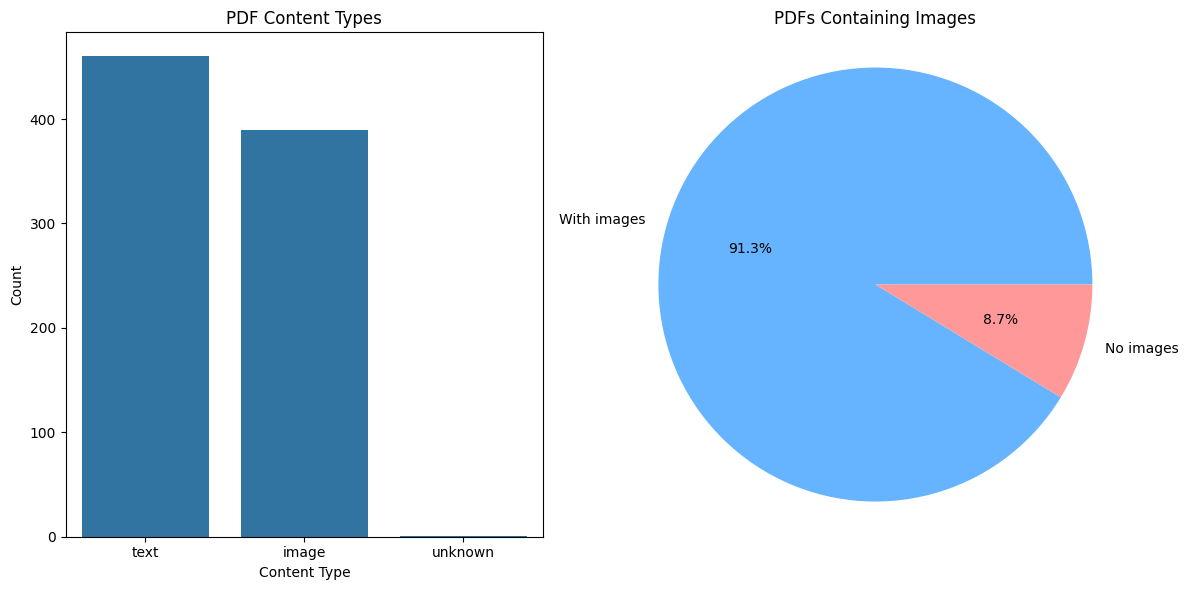

In [29]:
def plot_content_type_distribution(df):
    """Visualize distribution of PDF content types (text vs. image-based)."""
    if df.empty:
        print("No data available for visualization")
        return None
        
    plt.figure(figsize=(12, 6))
    
    # Content type distribution
    plt.subplot(1, 2, 1)
    content_counts = df['content_type'].value_counts()
    sns.barplot(x=content_counts.index, y=content_counts.values)
    plt.title('PDF Content Types')
    plt.ylabel('Count')
    plt.xlabel('Content Type')
    
    # Documents with images
    plt.subplot(1, 2, 2)
    image_counts = df['has_images'].value_counts()
    plt.pie([image_counts.get(True, 0), image_counts.get(False, 0)],
            labels=['With images', 'No images'],
            autopct='%1.1f%%',
            colors=['#66b3ff', '#ff9999'])
    plt.title('PDFs Containing Images')
    plt.axis('equal')
    
    plt.tight_layout()
    return plt

# Plot only if we have results
try:
    if 'result_df' in locals() and not result_df.empty:
        plot_content_type_distribution(result_df).show()
    else:
        print("No data available for visualization")
except NameError:
    print("Result dataframe not yet created")


In [30]:
def explore_pdf_extraction(file_name=None, index=0):
    """Explore the extraction results for a specific PDF.
    
    Args:
        file_name: Name of the PDF file to explore (if None, use index)
        index: Index of the PDF to explore if file_name is None
    """
    try:
        if 'result_df' not in locals() or result_df.empty:
            print("No extraction results available")
            return
            
        df = result_df  # Use the global result dataframe
        
        if file_name:
            # Find by file name
            pdf_data = df[df['file_name'] == file_name]
            if pdf_data.empty:
                print(f"No PDF with name '{file_name}' found")
                return
            pdf_data = pdf_data.iloc[0]  # Take the first match
        else:
            # Use index
            if index >= len(df):
                print(f"Index {index} out of range (0-{len(df)-1})")
                return
            pdf_data = df.iloc[index]
        
        # Display information
        print(f"\n{'='*60}")
        print(f"PDF: {pdf_data['file_name']}")
        print(f"{'='*60}")
        print(f"Content Type: {pdf_data['content_type']}")
        print(f"Pages: {pdf_data['page_count']}")
        print(f"File Size: {pdf_data['file_size_kb']:.1f} KB")
        print(f"Words: {pdf_data['word_count']}")
        print(f"Characters: {pdf_data['char_count']}")
        print(f"Paragraphs: {pdf_data['paragraph_count']}")
        print(f"Lines: {pdf_data['line_count']}")
        print(f"Has Images: {pdf_data['has_images']}")
        print(f"Image Count: {pdf_data['image_count']}")
        
        # If we have the full text, show a sample
        if 'extracted_text' in pdf_data and pdf_data['extracted_text']:
            # Check if it's just an error message
            if pdf_data['extracted_text'].startswith('[') and pdf_data['extracted_text'].endswith(']'):
                print(f"\nNo successful text extraction: {pdf_data['extracted_text']}")
                if "Tesseract" in pdf_data['extracted_text']:
                    print("\nTo extract text from image-based PDFs, please install Tesseract OCR:")
                    print("https://github.com/UB-Mannheim/tesseract/wiki")
            else:
                text_sample = pdf_data['extracted_text'][:500] + '...' if len(pdf_data['extracted_text']) > 500 else pdf_data['extracted_text']
                print(f"\nText Sample:\n{'-'*60}\n{text_sample}\n{'-'*60}")
        else:
            print("\nNo extracted text available in this dataset (excluded to save space)")
        
    except Exception as e:
        print(f"Error exploring PDF: {str(e)}")

# Example: Explore the first PDF in the results
# Uncomment and run this to explore a specific PDF
# explore_pdf_extraction(index=0)
